# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

This notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges a fictional company is facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

In [140]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Let's test it out! After running the following cell a new file `cifar.tar.gz` should be created in the file explorer.

In [141]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress the extracted dataset:

In [142]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them.

In [143]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [145]:
# Feel free to explore the datasets
for key in dataset_train.keys():
    try:
        print(f'{key}, Shape:{dataset_train[key].shape}, Element:{dataset_train[key][:5]}\n')
    except:
        print(
            f"{key}, Type:{type(dataset_train[key])}, Elements:{dataset_train[key][:5]}\n"
        )

b'filenames', Type:<class 'list'>, Elements:[b'bos_taurus_s_000507.png', b'stegosaurus_s_000125.png', b'mcintosh_s_000643.png', b'altar_boy_s_001435.png', b'cichlid_s_000031.png']

b'batch_label', Type:<class 'bytes'>, Elements:b'train'

b'fine_labels', Type:<class 'list'>, Elements:[19, 29, 0, 11, 1]

b'coarse_labels', Type:<class 'list'>, Elements:[11, 15, 4, 14, 1]

b'data', Shape:(50000, 3072), Element:[[255 255 255 ...  10  59  79]
 [255 253 253 ... 253 253 255]
 [250 248 247 ... 194 207 228]
 [124 131 135 ... 232 236 231]
 [ 43  32  87 ...  60  29  37]]



As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [147]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [148]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

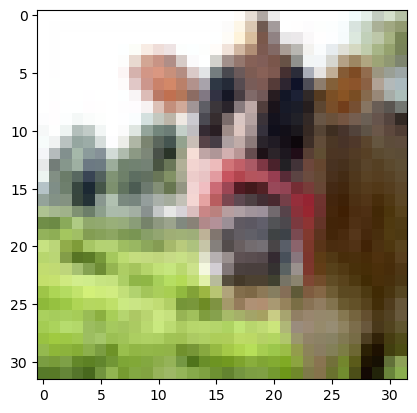

In [149]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [150]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [151]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


'cattle' sounds about right. Using the previous two lines we can do:

In [152]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now that we know how to check the labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [153]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [154]:
plt.imsave("file.png", test_image)

The new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that we know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. The fictional company can use a model that tells these apart to route delivery drivers automatically.

In the following cell, we will identify the label numbers for Bicycles and Motorcycles:

In [155]:
import pandas as pd

# create dataframe from dataset_meta dictionary
df_meta=pd.DataFrame(dataset_meta[b'fine_label_names'])

# convert byte values to strings
df_meta=df_meta.apply(lambda x: x.str.decode('utf-8'))

# filter dataframe to find label numbers for bicycle and motorcycle
print(df_meta.index[(df_meta.iloc[:, 0]=="bicycle") | (df_meta.iloc[:, 0]=="motorcycle")].tolist())

[8, 48]


We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we create a dataframe, and safely drop the rows that don't contain observations about bicycles and motorcycles.

In [156]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[df_train["labels"].isin([8, 48])]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)

df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test["labels"].isin([8, 48])]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

Now that the data is filtered for just our classes, we can save all our images.

In [157]:
!mkdir ./train
!mkdir ./test

We will now compose some of the previous code snippets together into a function that saves all the images into the `./test` and `./train` directories.

In [158]:
def save_images(dataset, idx, path='./images', filename="file.png"):
    #Grab the image data in row-major form
    img = dataset[idx]
    
    # Consolidated stacking/reshaping from earlier
    target = np.dstack((
        img[0:1024].reshape(32,32),
        img[1024:2048].reshape(32,32),
        img[2048:].reshape(32,32)
    ))

    # Save the image
    plt.imsave(path + '/' + filename, target)
    
    return 

# Save Train Images
for row in df_train.itertuples():
    index = (row[0])
    filename = (row[1])
    save_images(dataset_train[b"data"], index, "./train", filename)

# Save Train Images
for row in df_test.itertuples():
    index = (row[0])
    filename = (row[1])
    save_images(dataset_test[b"data"], index, "./test", filename)

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [1]:
import sagemaker

session = sagemaker.Session()

bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Default Bucket: sagemaker-us-east-1-641948205787
AWS Region: us-east-1
RoleArn: arn:aws:iam::641948205787:role/service-role/AmazonSageMaker-ExecutionRole-20240710T172011


With this data we can easily sync the data up into S3!

In [318]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
# already synced. Uncomment to sync to S3
#!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/;
#!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/;

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [161]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [162]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. We use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [95]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = sagemaker.image_uris.retrieve(framework="image-classification", region=region, version="latest")
s3_output_location = f"s3://{bucket}/models/image_model"

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


We're ready to create an estimator! Below, an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge` is created.

In [96]:
img_classifier_model=sagemaker.estimator.Estimator(
        role = role,
        image_uri = algo_image,
        instance_count = 1,
        instance_type = "ml.p3.2xlarge",
        output_path = s3_output_location
)

We can also set a few key hyperparameters and define the inputs for our model:

In [97]:
img_classifier_model.set_hyperparameters(
    image_shape = "3,32,32",
    num_classes = 2,
    num_training_samples = len(df_train),
)

The `image-classification` image uses four input channels with very specific input parameters defined below.

In [98]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs. In the cell below, we call the `fit` method on the model:

In [99]:
img_classifier_model.fit(model_inputs)

INFO:sagemaker:Creating training-job with name: image-classification-2024-08-04-18-30-50-876


2024-08-04 18:30:51 Starting - Starting the training job...
2024-08-04 18:30:51 Pending - Training job waiting for capacity....................................
2024-08-04 18:36:55 Pending - Preparing the instances for training...
2024-08-04 18:37:52 Downloading - Downloading the training image...........................
2024-08-04 18:42:05 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sun Aug  4 18:42:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Tem

We end up with a model topping out above 82% validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [100]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture = True,
    sampling_percentage = 100,
    destination_s3_uri = f"s3://{bucket}/data_capture"
)

Note the `destination_s3_uri` parameter: We can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, we'll deploy the model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [101]:
deployment = img_classifier_model.deploy(
    initial_instance_count = 1,
    instance_type = "ml.m5.xlarge",
    data_capture_config=data_capture_config,
    )

INFO:sagemaker:Creating model with name: image-classification-2024-08-04-19-00-22-180
INFO:sagemaker:Creating endpoint-config with name image-classification-2024-08-04-19-00-22-180
INFO:sagemaker:Creating endpoint with name image-classification-2024-08-04-19-00-22-180


------------!

In [102]:
endpoint = deployment.endpoint_name
print(endpoint)

image-classification-2024-08-04-19-00-22-180


We need to note the endpoint name for later as well.

Next, we'll instantiate a Predictor:

In [103]:
predictor=sagemaker.predictor.Predictor(
    endpoint_name=endpoint,
    sagemaker_session=session
)

In the code snippet below we prepare one of the saved images for prediction. We use the predictor to process the `payload`.

In [104]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

inference = predictor.predict(data=payload)

The `inference` object is an array of two values, the predicted probability value for each of the classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [105]:
print(inference)

b'[0.9076485633850098, 0.09235137701034546]'


### Draft Lambdas and Step Function Workflow

The operations team uses Step Functions to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug the workflow into the broader production architecture of the company.

In this next stage we're going to write and deploy three Lambda functions, and then use the Step Functions visual editor to chain them together! Our functions are going to work with a simple data object:

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

A good test object that we can use for Lambda tests and Step Function executions, throughout the next section, might look like this:

```python
{
  "image_data": "",
  "s3_bucket": MY_BUCKET_NAME, # Fill in with our bucket
  "s3_key": "test/bicycle_s_000513.png"
}
```

Using these fields, the functions can read and write the necessary data to execute the workflow. Let's start with the first function. The first Lambda function will copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

We go to the Lambda dashboard and create a new Lambda function with a descriptive name and select the 'Python 3.8' runtime. We add the same permissions as the SageMaker role we created earlier. This is done in the Configuration tab under "Permissions". Once ready, we craft the Lambda handler:


In [ ]:
# Lambda Handler for Serializing Image Data
import json
import boto3
import base64

s3 = boto3.client("s3")


def lambda_handler(event, context):
    """A function to serialize target data from S3"""

    print(event)
    # Get the s3 address from the Step Function event input
    key = event["s3_key"]
    bucket = event["s3_bucket"]

    # Download the data from s3 to /tmp/image.png
    s3.download_file(bucket, key, "/tmp/image.png")

    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        "statusCode": 200,
        "body": {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": [],
        },
    }

The next function is responsible for the classification part - we're going to take the image output from the previous function, decode it, and then pass inferences back to the the Step Function.

Because this Lambda will have runtime dependencies (i.e. the SageMaker SDK) we'll need to package them in the function. Read https://docs.aws.amazon.com/lambda/latest/dg/python-package-create.html#python-package-create-with-dependency
for more info on this process.

We create a new Lambda function for the image classifier with the same rights and a descriptive name.


In [ ]:
# Lambda Handler for Image Classification
import json
import sagemaker
import base64
from sagemaker.serializers import IdentitySerializer

# Fill this in with the name of the deployed model
ENDPOINT = "image-classification-2024-08-04-19-00-22-180"


def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(event["image_data"])

    # Instantiate a Predictor
    predictor = sagemaker.predictor.Predictor(
        endpoint_name=ENDPOINT, sagemaker_session=sagemaker.Session()
    )

    # For this model the IdentitySerializer needs to be "image/png"
    predictor.serializer = IdentitySerializer("image/png")

    # Make a prediction:
    inferences = predictor.predict(image)

    # We return the data back to the Step Function
    event["inferences"] = inferences.decode("utf-8")
    return {"statusCode": 200, "body": json.dumps(event)}

Finally, we need to filter low-confidence inferences. We define a threshold for the model. If the model predicts at `.70` for it's highest confidence label, do we want to pass that inference along to downstream systems? We make one last Lambda function and tee up the same permissions:

In [ ]:
# Lambda Handler for Threshhold
import json

THRESHOLD = 0.70

def lambda_handler(event, context):

    # Grab the inferences from the event
    inferences = json.loads(event["inferences"])

    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = True if max(inferences) > THRESHOLD else False

    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise ("THRESHOLD_CONFIDENCE_NOT_MET")

    return {"statusCode": 200, "body": json.dumps(event)}


With the lambdas in place, we can use the Step Functions visual editor to construct a workflow that chains them together. In the Step Functions console we have the option to author a Standard step function *Visually*.

When the visual editor opens, we have many options to add transitions in the workflow. We're going to keep it simple and have just one: to invoke Lambda functions. We are going to add three of them chained together. For each one, we'll be able to select the Lambda functions we just created in the proper order, filter inputs and outputs, and give them descriptive names.

We need to make sure that we:

1. Are properly filtering the inputs and outputs of the invokations (e.g. `$.body`)
2. Take care to remove the error handling from the last function - it's supposed to "fail loudly" for the operations colleagues!

The Step Function visual editor should look like the below screenshot

![Step_Fuction_Screenshot](img/StepFunction-Screenshot.jpg)


Great! Now we can use the files in `./test` as test files for our workflow. Depending on the threshold, the workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

Let's try several step function invokations using data from the `./test` folder. This process should give us confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of the data and inferences which we can visualize.

Here's a function that helps us generate test inputs for the invokations:

In [10]:
import random
import boto3
import json

def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')

    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="test")

    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])

    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })

for i in range(10):
    print(generate_test_case())

{"image_data": "", "s3_bucket": "sagemaker-us-east-1-641948205787", "s3_key": "test/bike_s_000801.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-641948205787", "s3_key": "test/motorcycle_s_001261.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-641948205787", "s3_key": "test/safety_bike_s_001132.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-641948205787", "s3_key": "test/motorcycle_s_001261.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-641948205787", "s3_key": "test/minibike_s_001732.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-641948205787", "s3_key": "test/minibike_s_000913.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-641948205787", "s3_key": "test/bicycle_s_000779.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-641948205787", "s3_key": "test/ordinary_bicycle_s_000350.png"}
{"image_data": "", "s3_bucket": "sagemaker-us-east-1-641948205787", "s3_key": "test/bicycle_s_000059.png"}
{"image_data": "", 

In the Step Function dashboard for the new function, we can create new executions and copy in the generated test cases. Let's do several executions so that we can generate data we can evaluate and visualize.

Once we've done several executions, let's visualize the record of our inferences. We pull in the JSONLines data from the inferences like so:

In [260]:
from sagemaker.s3 import S3Downloader

# In S3 the data will be saved to a datetime-aware path
# Find a path related to a datetime we're interested in
data_path = "s3://sagemaker-us-east-1-641948205787/data_capture/image-classification-2024-08-04-19-00-22-180/AllTraffic/2024/08/05/02/06-04-624-3ef79325-9bb8-4b28-aa84-81ea7d235883.jsonl"

S3Downloader.download(data_path, "captured_data")

# Feel free to repeat this multiple times and pull in more data

['captured_data/06-04-624-3ef79325-9bb8-4b28-aa84-81ea7d235883.jsonl']

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [5]:
!pip install jsonlines
import jsonlines

  Using cached jsonlines-4.0.0-py3-none-any.whl.metadata (1.6 kB)
Using cached jsonlines-4.0.0-py3-none-any.whl (8.7 kB)


Now we can extract the data from each of the source files:

In [7]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")
print(file_handles)

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        for obj in f:
            json_data.append(obj)

['04-02-796-e88f39ad-abcf-4605-b1a9-6a13cc095b69.jsonl', '05-03-418-6270df80-df44-453a-87f1-9805f7616fca.jsonl', '06-04-624-3ef79325-9bb8-4b28-aa84-81ea7d235883.jsonl', '07-06-360-f9817a47-fce3-423b-958f-2368352341ea.jsonl']


The data should now be a list of dictionaries, with significant nesting. Here's some code that grabs data out of the objects and visualizes it:

In [307]:
# Define how we'll get our data

def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

Finally, here's a visualization built with this data. The captured data has the input images, the resulting inferences, and the timestamps.

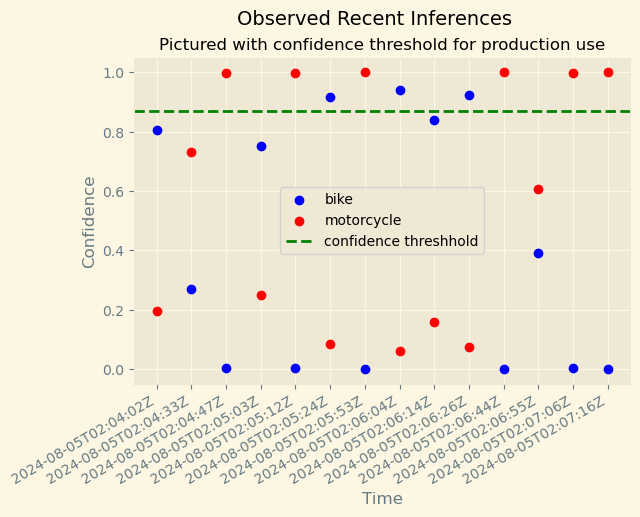

In [317]:
import matplotlib.pyplot as plt

# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    y.append(inference)
    x.append(timestamp)

#plot the data
for i in range(len(x)):
    scatter_bike = plt.scatter(x[i], y[i][0], c="b", label="bike")
    scatter_motorcycle = plt.scatter(x[i], y[i][1], c="r", label="motorcycle")

plt.suptitle("Observed Recent Inferences", fontsize=14)
plt.title("Pictured with confidence threshold for production use", fontsize=12)
plt.xlabel("Time")
plt.ylabel("Confidence")
plt.gcf().autofmt_xdate()
threshhold = plt.axhline(y=0.87, color='g', linestyle='--', label="confidence threshhold")
plt.legend(handles=[scatter_bike, scatter_motorcycle, threshhold], loc=10)
plt.show()

### Summary

In this workflow we created an event-driven ML workflow that can be incorporated into a company's production architecture. We used the SageMaker Estimator API to deploy the SageMaker Model and Endpoint, and used AWS Lambda and Step Functions to orchestrate the ML workflow. Using SageMaker Model Monitor, we instrumented and observed the Endpoint, and at the end of the project we built a visualization to help stakeholders understand the performance of the Endpoint over time.